# Support Vecor Machine (SVM)
<!--
Author: Zhaoqiang SHEN
Date: 2018/08/22
Contact: szqtclx@gmail.com
-->

### SVM 算法特点
优点：泛化（由具体的、个别的扩大为一般的，就是说：模型训练完后的新样本）错误率低，计算开销不大，结果易理解。  
缺点：对参数调节和核函数的选择敏感，原始分类器不加修改仅适合于处理二分类问题。  
使用数据类型：数值型和标称型数据。

In [1]:
import copy
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import svm

## 线性核SVC

### 硬间隔SVC
对于一个线性可分的训练集，多个平面可以分解数据。即有，  
${\bf w}^T {\bf x}_i + b \geq +1$, for $y_i = +1$,  
${\bf w}^T {\bf x}_i + b \leq   -1$, for $y_i = -1$.

距离平面最近的两类训练样本成为**支持向量**，两异类支持向量到平面距离的和称为**间隔**，它等于$2/\|{\bf w} \|$。SVM希望去找间隔最大的平面。  
因此SVM的**基本型**写为，  
优化目标：$\min_{{\bf w}, b} \frac{1}{2} \| {\bf w} \|^2$  
s.t. $y_i ({\bf w}^T {\bf x}_i+b) \geq 1$, for every $i=1,2,3, \cdots, m.$

利用拉格朗日乘子法，有$L({\bf w}, b, {\bf \alpha}) = \frac{1}{2} \| {\bf w} \|^2 + \sum_i \alpha_i (1-y_i ({\bf w}^T {\bf x}_i+b))$。   
当**强对偶性**成立时（Slater条件：对于凸函数，如果存在一个点使不等式约束严格成立，则满足强对偶性；对于非凸函数情况下通常不成立），主问题与对偶问题的解相等（否则后者小于前者），即$\min_{{\bf w}, b} \max_{\alpha_i} L({\bf w}, b, {\bf \alpha}) = \max_{\alpha_i} \min_{{\bf w}, b} L({\bf w}, b, {\bf \alpha})$，  
其中**对偶问题**为  
$RHS = \boxed {\max_{\alpha} \sum_{i=1}^m \alpha_i - \frac{1}{2} \sum_i \sum_j \alpha_i \alpha_j y_i y_j {\bf x}_i^T {\bf x}_j }$,  
s.t. $\sum_i \alpha_i y_i = 0$, and $\alpha_i \geq 0$.

强对偶同样导致KKT条件成立，  
- dual feasible: $\alpha_i \geq 0$,  
- prime feasible: $y_i ({\bf w}^T {\bf x}_i+b) \geq 1$, and   
- complementary slackness: $\alpha_i (1-y_i ({\bf w}^T {\bf x}_i+b)) = 0$，  

从KKT条件上来看，对于不在最大间隔边界上的点，其满足$y_i f({\bf x}_i)-1>0$，因此需要$\alpha_i=0$，它们也就对参数没有影响。事实上SVM只与支持向量相关。

### 软间隔SVC
当不能线性可分时（即存在不满足$y_i ({\bf w}^T {\bf x}_i + b) \geq 1$的样本点），我们希望不满足约束者越少越好。则优化目标改写为：  
$\min_{{\bf w}, b} \frac{1}{2} \| {\bf w} \|^2 + C \sum_{i=1}^m \ell(y_i ({\bf w}^T {\bf x}_i + b) )$  
其中，损失函数包括：
- 0/1 损失函数：$\ell_{0/1}(z) = H(-z) $
- Hinge 损失函数：$\ell_{hinge}(z) = \max(0, 1-z)$
- 对数损失函数：$\ell_{exp}(z) = \exp(-z)$
- 对率损失函数：$\ell_{log}(z) = \log_2(1+\exp(-z))$

对于Hinge Loss，引入**松弛变量**$\xi_i = \ell_{hinge}(y_i ({\bf w}^T {\bf x}_i + b))$，则优化目标写为：  
$\min_{{\bf w}, b, {\bf \xi}} \frac{1}{2} \| {\bf w} \|^2 + C \sum_{i=1}^m \xi_i$，  
其中，$ \xi_i \geq 0$ and $\xi_i \geq 1-y_i ({\bf w}^T {\bf x}_i + b)$。

得到拉格朗日函数：$L({\bf w}, b, {\bf \xi}, {\bf \alpha}, {\bf \mu}) = \frac{1}{2} \| {\bf w} \|^2 + C\sum_i \xi_i + \sum_i \alpha_i (1-\xi_i-y_i ({\bf w}^T {\bf x}_i+b)) - \sum_i \mu_i \xi_i$。  
它的对偶问题为：
$\max_{\alpha} \sum_{i=1}^m \alpha_i - \frac{1}{2} \sum_i \sum_j \alpha_i \alpha_j y_i y_j {\bf x}_i^T {\bf x}_j $,  
s.t. $\sum_i \alpha_i y_i = 0$, and $\boxed {0 \leq \alpha_i \leq C}$.  

因为强对偶，所以KKT条件成立：  
- dual feasible: $\alpha_i \geq 0$, and $\mu_i \geq 0$,  
- prime feasible: $1-\xi_i - y_i ({\bf w}^T {\bf x}_i+b) \leq 0$, and $-\xi_i \leq 0$,  
- complementary slackness: $\alpha_i (1-\xi_i-y_i ({\bf w}^T {\bf x}_i+b))=0$, and $\mu_i \xi_i=0$.

由KKT条件可知，满足$1-\xi_i=y_i ({\bf w}^T {\bf x}_i+b)$的向量（支持向量）对参数有影响，也就是说Hinge Loss保持了SVM的稀疏性。  
另外由于$\alpha_i+\mu_i=C$，如果某个点有$\alpha_i = C$，则$\mu_i=0$， $\xi_i > 0$，因此它落在最大间隔内部。

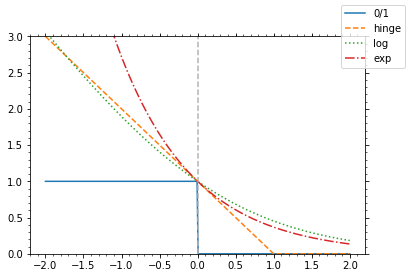

In [2]:
# Loss functions
fg0 = plt.figure()
ax0 = fg0.add_subplot(111)

x = np.linspace(-2., 2., 300)
ax0.plot(x, x<0., ls='-', label='0/1')
ax0.plot(x, np.maximum(0., 1.-x), ls='--', label='hinge')
ax0.plot(x, np.log2(1.+np.exp(-x)), ls=':', label='log')
ax0.plot(x, np.exp(-x), ls='-.', label='exp')

ax0.plot([0., 0.], [0., 3.], ls='--', c='0.7')
ax0.set_ylim((0., 3.))
fg0.legend()

### 求解SVC

上述对偶问题是二次规划问题，因此可以用常用的二次规划解法：椭球法(ellipsoid method)，内点法(interior method)，增广拉格朗日法(augmented Lagrangian)，梯度投影法(gradient projection)等。但这些方法运算规模正比于训练样本数，造成很大的运算开销。

#### SMO (Sequential Minimal Optimization)
[SMO算法](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf)利用了SVC问题的特点使得求解更为高效：它每次选取一对参数$\alpha_i$, $\alpha_j$，因为有$\sum_i \alpha_i y_i = 0$，所以$\alpha_i y_i + \alpha_j y_j = c \equiv -\sum_{k \neq i,j} \alpha_k y_k$，消去对偶问题中的$\alpha_j$，即可得到一个关于$\alpha_i$的二次函数，这个函数的解易得。通过反复选取参数对进行更新，参数会慢慢收敛。

```
SMO(X, y, C, tol)
1  alpha = zeros(m)
2  for i=1 to N
3      选取一对要更新的变量alpha1, alpha2
4      解关于alpha1, alpha2对偶问题的对偶问题，得到新的alpha
5  找出支持所有向量S，得到b的值。
```

下面是几点细节：
- 关于选取要更新的$\alpha_1$和$\alpha_2$：$\alpha_1$先选择为偏离KKT条件程度最大的变量，$\alpha_2$则选择使两变量对应的样本间隔最大。

- 关于求解$\alpha_1$, $\alpha_2$对偶问题：若假设$\alpha'_1=\alpha_1 + \Delta \alpha_1$，则易得
$\Delta \alpha_1 = \frac{1}{y_1 \| {\bf x}_1 - {\bf x}_2\|^2} \left \{ (y_1-y_2)\left[1+\frac{1}{y_1 y_2} \right] + E_2 - E_1 \right \} \overset{|y_i|=1}{=} \frac{y_1 (E_2 - E_1)}{\| {\bf x}_1 - {\bf x}_2 \|^2} $，
$\Delta \alpha_2$同理。

- 关于在软间隔SVC中更新$\alpha_1$和$\alpha_2$：
    ![smo](figures/smo1.png)   
    当$y_1 \neq y_2$时，$\alpha'_1$取值下限：$\max (0, \alpha_1-\alpha_2)$，取值上限为：$\min (C, C+\alpha_1-\alpha_2)$。左图显示了$0 \leq \alpha'_1 \leq C+\alpha_1-\alpha_2$。  
    当$y_1 = y_2$时，$\alpha'_1$取值下限：$\max (0, \alpha_1+\alpha_2-C)$，取值上限为：$\min (C, \alpha_1+\alpha_2)$。右图显示了$0 \leq \alpha'_1 \leq \alpha_1+\alpha_2$。  

- 关于求解b的值：支持向量满足$y ({\bf w}^T{\bf x}+b) = 1$。计算b时，我们考虑所有支持向量的贡献：$\sum_{s \in S} \left [({\bf w}^T {\bf x}_s + b)  - 1/y_s \right] = 0$。


In [3]:
!head machinelearninginaction/Ch06/testSet.txt

In [4]:
# 一组线性可分的数据
input_data = np.loadtxt('machinelearninginaction/Ch06/testSet.txt')
X1 = input_data[:, :-1]
y1 = input_data[:, -1]

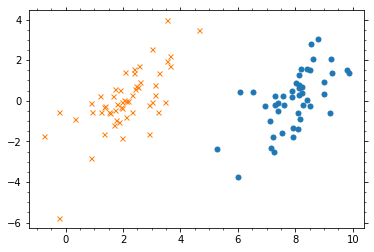

In [5]:
fg1 = plt.figure()
ax1 = fg1.add_subplot(111)
ax1.plot(X1[y1>0, 0], X1[y1>0, 1], marker='o', ms=5, ls='None')
ax1.plot(X1[y1<0, 0], X1[y1<0, 1], marker='x', ms=5, ls='None')

In [6]:
# SMO算法，参考Machine Learning in Action (chs), pp.94-105
def w_lin(alpha, X_data, y_data):
    """
    Parameters
    -------------
    alpha : (m, 1) array, >=0.
        dual parameters
    X_data : (m, n) array
        training data
    y_data : (m, 1) array, =+/-1
        the label of training data

    Returns
    ---------
    w: (n, 1) array
        weight vector
    """
    assert alpha.ndim == 2 and y_data.ndim == 2
    return (alpha*y_data*X_data).sum(axis=0, keepdims=True).T

def model_lin(X, w, b):
    """
    Parameters
    -------------
    X : (m', n) array
        input features
    w : (n, 1) array
        weight vector
    b : scalar
        bias term
    
    Returns
    ---------
    y_pred : (m', 1)
        predicted labels of input features
    """
    assert X.ndim == 2 and w.ndim == 2
    return X@w + b # np.dot(X, w) + b

def update_alpha(alpha, i, j, C, X_data, y_data):
    """
    Update the dual parameters based on SMO algorithm
    
    Parameters
    -------------
    alpha : (m, 1) array, >=0.
        dual parameters
    i, j : integer, >=0, i != j
        the term of alpha needed to be update
    C : scalar, >0.
        constant to control the regularization
    X_data : (m, n) array
        training data
    y_data : (m, 1) array, =+/-1
        the label of training data
    
    Returns
    ---------
    is_updated : bool
        whether the update is performed
    """
    assert i>=0 and j>=0 and C>0. and i!=j
    w = w_lin(alpha, X_data, y_data)

    xi, yi = X_data[i:i+1, :], y_data[i] # xi in (1, n), yi is scalar
    yi_pred = model_lin(xi, w, 0.) # b is canceled out, so here we just use b=0
    Ei = yi_pred - yi
    
    xj, yj = X_data[j:j+1, :], y_data[j]
    yj_pred = model_lin(xj, w, 0.)
    Ej = yj_pred - yj

    alpha_i, alpha_j = alpha[i], alpha[j]
    if yi*yj < 0:
        L = max(0., alpha_i-alpha_j)
        H = min(C, C+alpha_i-alpha_j)
    else:
        L = max(0., alpha_i+alpha_j-C)
        H = min(C, alpha_i+alpha_j)
    if L == H: return False

    dalpha_i = yi/((xi-xj)**2).sum() * (Ej - Ei)
    alpha_i_new = np.clip(alpha_i+dalpha_i, a_min=L, a_max=H)
    alpha_j_new = (alpha_i-alpha_i_new)*yi*yj + alpha_j # a1y1 + a2y2 = a'1y1 + a'2y2, |yi|=1
    
    alpha[i] = alpha_i_new
    alpha[j] = alpha_j_new
    return True
    
def support_vector_indices(alpha):
    """
    Find the indices of support vectors, which satisfies
    \alpha_i != 0. due to the KKT condition.
    
    Parameters
    -------------
    alpha : (m, 1) array, >=0.
        dual parameters
        
    Returns
    ---------
    indexes : array of non-negative integers
        the index of support vectors in the data
    """
    return np.nonzeros(alpha>0.)[0]

def calculate_b(alpha, X_data, y_data):
    """
    Calculate the bias term of the model.
    
    Parameters
    -------------
    alpha : (m, 1) array, >=0.
        dual parameters
    X_data : (m, n) array
        training data
    y_data : (m, 1) array, =+/-1
        the label of training data
        
    Returns
    ---------
    b : scalar
        the bias/interception of linear model
    """
    idxs = support_vector_indices(alpha)
    X_sv, y_sv = X_data[idxs, :], y_data[idxs, :]

    w = w_lin(alpha, X_data, y_data)
    b = sum(1./y_sv - X_sv@w) / len(idxs)
    return b

def select_IJ():
    pass

#### sklearn
`scikit-learn`中提供了`libsvm`和`liblinear`两个接口用来求解线性SVC问题。前者使用了二次规划方法，时间复杂度在$O(n\,m^2)$到$O(n \, m^3)$之间；而后者专门解决线性SVM问题，时间复杂度为$O(m)$[(scikit-learn.org)](http://scikit-learn.org/stable/modules/svm.html#complexity)。

In [7]:
svc = svm.LinearSVC() # liblinear
svc.fit(X1, y1)
print(svc.coef_, svc.intercept_) # w1, w2, b

[[ 0.43605435 -0.206283  ]] [-2.12429863]


In [8]:
svc2 = svm.SVC(kernel='linear') # libsvm
svc2.fit(X1, y1)
print(svc.coef_, svc.intercept_) # w1, w2, b

[[ 0.43605435 -0.206283  ]] [-2.12429863]


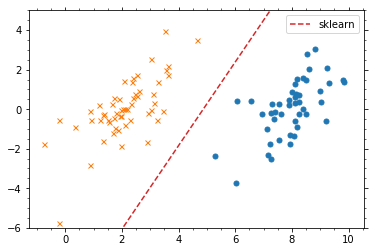

In [9]:
x_ = np.array([0., 10.])
y_ = -(svc.intercept_+svc.coef_[0, 0]*x_)/svc.coef_[0, 1]
ax1.plot(x_, y_, ls='--', c='C3', label='sklearn')
ax1.set_ylim((-6, 5))
ax1.legend()
fg1

## 核技巧


## SVR